In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from random import shuffle
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam
from rdkit import Chem, ML
from rdkit.Chem import AllChem
from rdkit.ML import Scoring
from rdkit.ML.Scoring import Scoring
from rdkit.ML.Scoring.Scoring import CalcAUC, CalcBEDROC, CalcEnrichment
from sklearn import metrics as mt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error as sk_mean_squared_error
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score, mean_squared_log_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

pd.options.display.max_columns = 100

## Dataset Overview and Problem Statement

> Give an overview of the dataset you have chosen to use.
>
>    - What is the classification task and what is the format of the feature data. Is this multi-task, multi-modal, or both? Explain.
>    - Who collected the data? Why? When?
>    - What evaluation criteria will you be using and why? 

For this lab, we will explore classifying the reactions of assays with chemical compounds and assign whether an assay is binding or non-binding based on the vector structure of a compound.  This exercise will be a multi-task classification where the "pref_name", or preferred target name, is the task.  Multi-task is most appropriate for this dataset as this dataset allows us to segregate targets and perform predictions on those targets.  Multi-modal is not an appropriate framework as this dataset does not support intuitive modes of data - think traditional modes such as audio, video, text, etc.  This dataset is tabled data.

This dataset is collected by and maintained by the European Molecular Biology Laboratory's European Bioinformatics Institue, EMBL-EBI.  The ChemBL dataset is a dataset containing molecules and various bio-properties of these molecules gathered while performing drug testing.  This dataset is primarily used to discover associations and reactions to certain assays which furthers drug development in the medical field.  In addition to qualitative and quantitative data about compounds, this dataset also includes compound structures (which can be converted into vectorized form as discovered in this exercise).

Evaluation Criteria:
    
    - F1: 
    - AUC: 
    - BEDROC? 
    - Enrichment

We decided to use the F1-score evaluation metric because our dataset has a large imbalance in our target classes. As we can see below, only ~16% of the data contains employees who quit, while the other ~84% are employees who stayed with the company. Accuracy would be a poor measurement for this dataset, since by just guessing stay, the model would be correct 84% of the time. F1-score takes into account the class imbalance to give us an accurate reading of how well the model performs in our binary classification task.

## Utility Functions

In [2]:
# CHATGPT GENERATED CODE
# Define a function to generate fingerprints
def generate_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048)
    features = np.zeros((1,))
    Chem.DataStructs.ConvertToNumpyArray(fp, features)
    return features


In [3]:
# CLASSROOM CODE
def bland_altman_plot(data1, data2, *args, **kwargs):
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    
    plt.figure(figsize=(15,10))
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.title("Bland Altman, MSE: "+str(sk_mean_squared_error(data1,data2)))
    plt.xlabel('Mean Score', fontsize=8)
    plt.ylabel('Diff Score', fontsize=8)
    plt.show()

In [77]:
# CLASSROOM CODE
def step(key_order, opt, X_train, y_train, models_mtl):
    # accumulate all the operations for the dataset
    preds = {} 
    loss = {}  
    tapes = {} 
    
    for x in key_order:
        with tf.GradientTape() as tape:
            tapes[x[0]] = tape
            # make a prediction and calculate loss for each task
            preds[x[0]] = models_mtl[x[0]](X_train[x[0]])
            loss[x[0]] = mean_squared_error(y_train[x[0]], preds[x[0]])
            
    # now batch update all the models with the gradients
    for x in key_order:
        grads = tapes[x[0]].gradient(loss[x[0]], models_mtl[x[0]].trainable_variables)
        opt[x[0]].apply_gradients(zip(grads, models_mtl[x[0]].trainable_variables))

In [5]:
def roc_calc(model, X_test, y_test):
    yhat = model.predict(X_test)
    false_positive, true_positive, _ = mt.roc_curve(y_test.flatten(), yhat.flatten())
    roc = mt.auc(false_positive, true_positive)
    return false_positive, true_positive, roc

In [6]:
def f1_score_calc(precision, recall):
    return 2 * np.multiply(precision, recall)/np.add(precision, recall)

In [ ]:
def avg_metric(scores, metric="precision"):
    # get the average precision for both the first DNN and the best NN
    metric_table = []
    for score in scores:
        if metric_table:
            metric_table = list(np.add(score[metric], metric_table))
        else:
            metric_table += score[metric]    
    metric_table = np.divide(metric_table,5)
    
    return metric_table

## Dataset Preprocessing

MySQL Query used to create the "raw" data from chemBL - note that we do filter to IC50 standard type and nM for our standard units as our only transformations prior to bringing this data into a Python Environment.  We do this to limit the size of the data ingested.  Additionally, we select on choice columns from our first table (Activities) as these columns we believed to be most important and all other columns to be irrelevant or redundant.
```
SELECT  a.standard_value,
        b.le,
        d.target_type,
        d.pref_name,
        e.canonical_smiles,
        f.molecular_species
FROM chembl.activities a

inner join chembl.ligand_eff b
on a.activity_id = b.activity_id

inner join chembl.assays c
on a.assay_id = c.assay_id

inner join chembl.target_dictionary d
on d.tid = c.tid

inner join chembl.compound_structures e
on a.molregno = e.molregno

inner join chembl.compound_properties f
on a.molregno = f.molregno

where a.standard_type = 'IC50' and a.standard_units = 'nM' and (a.standard_value <= 300 or a.standard_value >= 10000);
```

In [7]:
# read in data
df = pd.read_csv("chemBL.csv")

In [8]:
# print length and show sample data
print(len(df))
df.head()

562960


,standard_value,le,target_type,pref_name,canonical_smiles,molecular_species
0,17000.0,0.20,SINGLE PROTEIN,Palmitoyl-CoA oxidase,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)NCCc4ccccc4)CC...,NEUTRAL
1,180.0,0.25,SINGLE PROTEIN,Palmitoyl-CoA oxidase,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccc...,NEUTRAL
2,29.4,0.43,SINGLE PROTEIN,Beta-1 adrenergic receptor,CC(C)(C)NC[C@H](O)CON=C1c2ccccc2-c2ccccc21,BASE
3,30.8,0.43,SINGLE PROTEIN,Beta-2 adrenergic receptor,CC(C)(C)NC[C@H](O)CON=C1c2ccccc2-c2ccccc21,BASE
4,120.0,0.56,PROTEIN COMPLEX GROUP,GABA-A receptor; anion channel,CCOC(=O)c1cn2c(n1)sc1ccccc12,NEUTRAL


In [9]:
# binarize ligand values based on ranges <=300 nM and >=10000 nM (1 for active, 0 for inactive respectively)
df.loc[df["standard_value"] <= 300.0, "standard_value_bin"] = 1
df.loc[df["standard_value"] >= 10000.0, "standard_value_bin"] = 0

>[1.0 points] How many tasks or modalities are there in the dataset and how do you define each task or modality? That is, explain if the task is within the same domain, cross domains, etc. If there are too many tasks or modalities to train the data reasonably, select a subset of the tasks for classification. For example, you might want to only train on 50 of the classification tasks.

This dataset contains 3,279 tasks.  These tasks are of the same domain - target names as it relates to compound reactivities.  For this exercise, we have reduced this down to 100 tasks.  Around the 100th task, each task will have about 1,000 records.  We determined this would be the limit to the amount of records that would be adequate for training and testing.  Therefore, we finalized our approach with using 100 tasks.  We lose ~55% of our data, but we argue that the top 100 targets have enough datapoints to be worth training and testing our model.  Including more tasks would create sparsity within our dataset and model.

(array([106465.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 456495.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

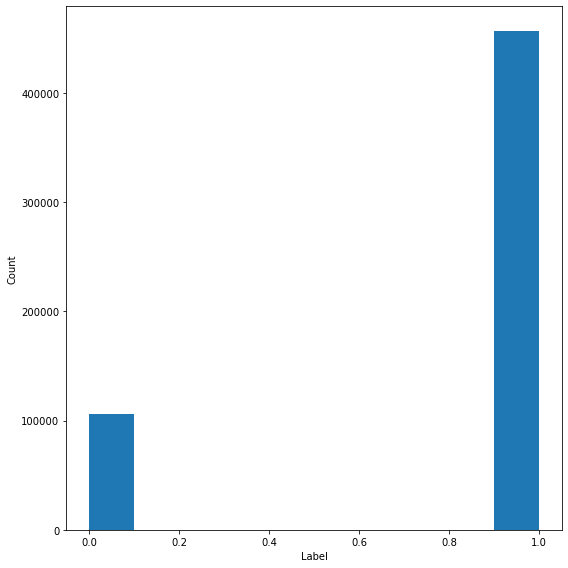

In [10]:
# plot out each label
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
fig.set_figheight(8)
fig.set_figwidth(8)
axs.set_xlabel("Label")
axs.set_ylabel("Count")
axs.hist(df["standard_value_bin"])

In [12]:
y = df["standard_value_bin"]
X = df
del X["standard_value_bin"]

In [17]:
# under sample datasets to address class imbalancing
under_sample = RandomUnderSampler(sampling_strategy = 0.7)
X_under, y_under = under_sample.fit_resample(X, y)

df = pd.concat([X_under, y_under], axis=1)

(array([106465.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 152092.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

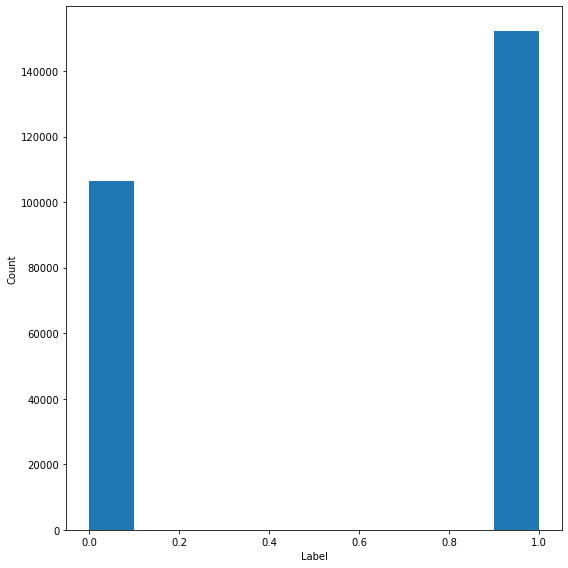

In [18]:
# plot out each label
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
fig.set_figheight(8)
fig.set_figwidth(8)
axs.set_xlabel("Label")
axs.set_ylabel("Count")
axs.hist(df["standard_value_bin"])

In [19]:
print("Total Number of Tasks: ", len(df["pref_name"].unique()))

Total Number of Tasks:  3279


In [24]:
# determine the assay count by target name
targets = df.groupby("pref_name")[["target_type"]].agg({"target_type": "count"}).sort_values(by="target_type", ascending=False)
targets["cumulative_count"] = targets["target_type"].cumsum()
targets["cumulative_perc"] = targets["cumulative_count"]/sum(targets["target_type"])

# filter down df to top 100 targets
df = df[df["pref_name"].isin(targets.iloc[:40].index)]

In [25]:
print("Record count at the 100th target ", targets.iloc[40]["target_type"])

Record count at the 100th target  986.0


In [27]:
print("Cumulative Record Count in Reduced Dataset: ", targets["cumulative_perc"][40])

Cumulative Record Count in Reduced Dataset:  0.6035035640334964


(array([12339.,  6948.,  5990.,  5884.,  5607.,  4490.,  7932.,  5016.,
         5444.,  5234.]),
 array([ 0. ,  3.9,  7.8, 11.7, 15.6, 19.5, 23.4, 27.3, 31.2, 35.1, 39. ]),
 <BarContainer object of 10 artists>)

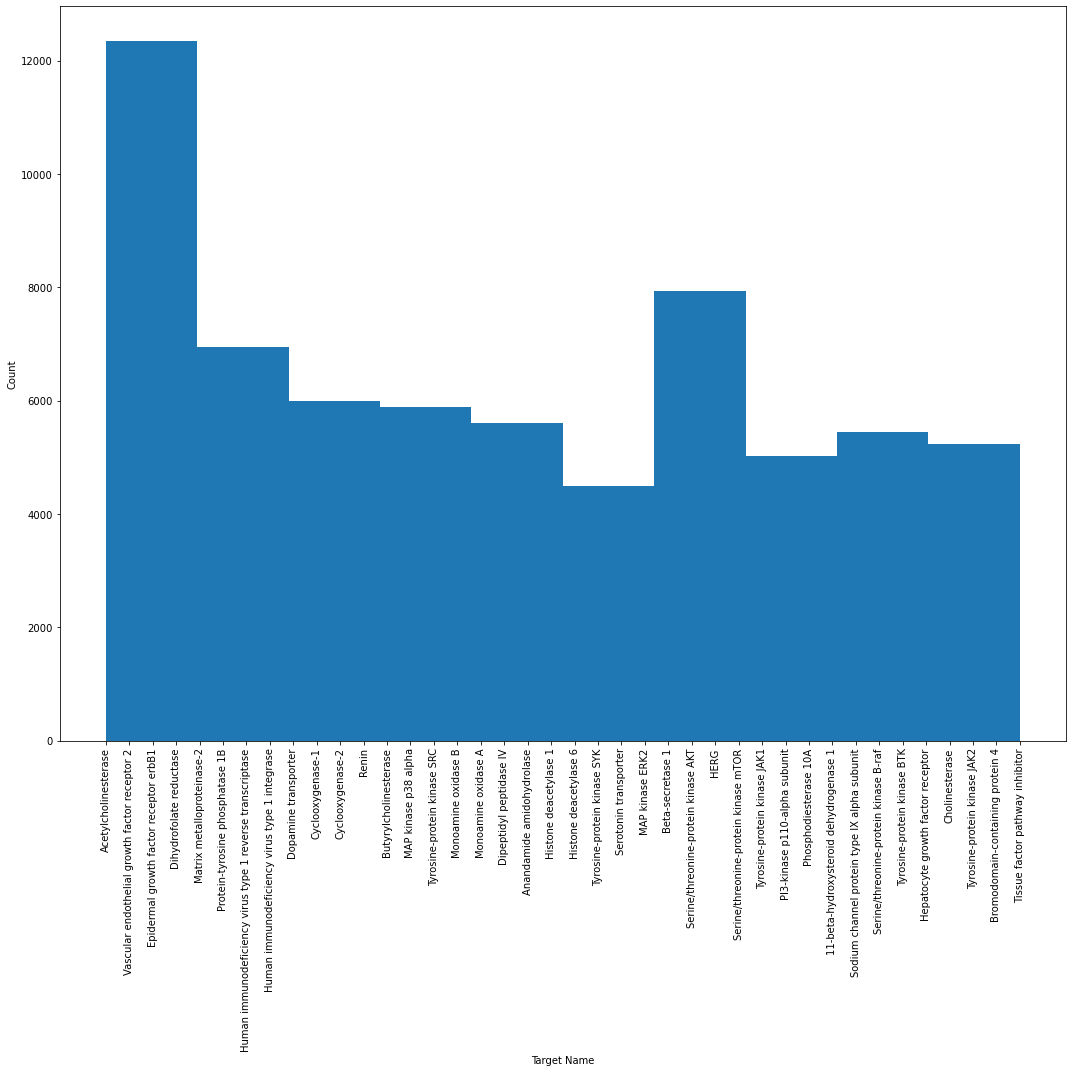

In [28]:
# plot out each set of tasks
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
fig.set_figheight(15)
fig.set_figwidth(15)
axs.set_xlabel("Target Name")
axs.set_ylabel("Count")
plt.xticks(rotation=90)
axs.hist(df["pref_name"])

(array([26202.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 38682.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

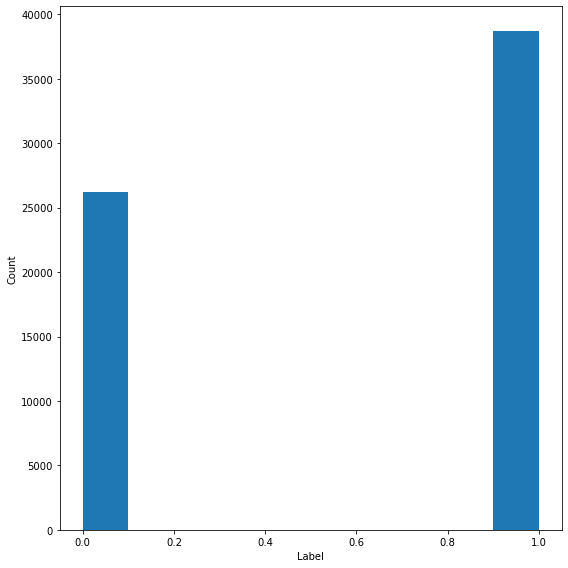

In [31]:
# plot out each label
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
fig.set_figheight(8)
fig.set_figwidth(8)
axs.set_xlabel("Label")
axs.set_ylabel("Count")
axs.hist(df["standard_value_bin"])

In [29]:
# Apply the function to each row of the DataFrame
df['Fingerprint'] = df["canonical_smiles"].apply(generate_fingerprint)

In [32]:
# initialize empty list of X and y values
task_X_list = []
task_y_list = []

# for each target, create a list of fingerprint values and associated labels
for target in df["pref_name"].unique():
    X = np.array(df[df["pref_name"] == target]["Fingerprint"].tolist())
    y = df[df["pref_name"] == target]["standard_value_bin"].values

    task_X_list.append((target, X))
    task_y_list.append((target, y))

>[1.0 points] Split the data into training and testing. Be sure to explain how you performed this operation and why you think it is reasonable to split this particular dataset this way. For multi-task datasets, be sure to explain if it is appropriate to stratify within each task. If the dataset is already split for you, explain how the split was achieved and how it is stratified.

Since our dataset has ~250,000 records, we decided to split our data into 80% training, 20% testing. For the generalized model, we need to combine all of the tasks into a single task.  Of the 80% training data, we will perform another split using cross validation (CV).  We CV split the data 5 times, as we keep consistent with the above 80/20 method (5 splits means 4 are training, 1 is testing per iteration - or 80/20).  We use a stratified K-Fold approach for two reasons: 1. K-Fold allows us to have an even 5-way split, keeping our training and validation data consistent with the above 80/20 rule, 2. Stratification is needed as described above because the distribution of the outputs are uneven - where roughly 35,000 are classified as 0, or non-binding and 215,000 are classified as binding.  For each task, we will also stratify the classification labels as we believe that each task follows a similar pattern to the entire population.

In [ ]:
# X_train = dict()
# y_train = dict()
# X_test = dict()
# y_test = dict()

# for x in tasks.keys():
#     X_train[x], X_test[x], y_train[x], y_test[x] = train_test_split(tasks[x].data, 
#                                                         tasks[x].target, 
#                                                         test_size=0.4, 
#                                                         random_state=42)

In [33]:
all_data = {"data": [], "target": [], "data_test": [], "target_test": []}

X_train = dict()
y_train = dict()
X_test = dict()
y_test = dict()

for x,y in zip(task_X_list, task_y_list):
    X_train[x[0]], X_test[x[0]], y_train[x[0]], y_test[x[0]] = train_test_split(x[1], 
                                                                                y[1], 
                                                                                test_size=0.2, 
                                                                                random_state=7)
    
    all_data["data"].append(X_train[x[0]])
    all_data["target"].append(y_train[x[0]])        
    all_data["data_test"].append(X_test[x[0]])
    all_data["target_test"].append(y_test[x[0]])

X_train_all = np.concatenate(all_data["data"])
y_train_all = np.concatenate(all_data["target"])

X_test_all = np.concatenate(all_data["data_test"])
y_test_all = np.concatenate(all_data["target_test"])

>[3.0 points] Train a general model (or per task model) to perform the classification tasks. That is, a general model uses all modalities and all tasks should combined into a single classification task (if possible). Alternatively, if this is not possible, you could create a model for each specific task. For a task specific model, each task would be classified with its own feed-forward model.

Our first model approach is to create a general MLP in where we predict each compound structure reaction as non-binding (0) or binding (1).  We opt for a large model structure because we believe that more model parameters and layers will help generalize the model on our 2,048 feature vectors.  In terms of layer design, there is no empirical reason why we start our lower layer at 512 units, however, our philosophy is to decrease layer size for each additional layer by a factor of 2.  We want our layers to approach a smaller number of neurons as the layer count increases because our output is binary.  For activation, we chose ReLU because of the simplicity and our use-case of binary classification fits this activation function well without ghosting the gradients.  Droupout is used as a standard approach to curtail overfitting - previous iterations where we ran with no dropout, we experienced severe overfitting and we found that incorporating 20% dropout in most layers decreased overfitting.  Finally, our last layer has an activation of sigmoid as we found that sigmoid was the best activation for our use case - as opposed to softmax.

For our optimizer, we used ADAM as this is standard and safe to use for binary classification.  Our learning rate, we start at small to curtail above mentioned overfitting.  Our loss function is binary_crossentropy due to the nature of our dataset and labels being binary.  For metrics, we gather precision, accuracy, recall, and AUC for later analysis

In [46]:
# initialize model
model = Sequential()

# add input layer plus dropout after first dense layer
model.add(Dense(input_dim=X_train_all.shape[1], units=512, activation='relu', name='input_dense512'))
model.add(Dropout(0.2))

# second layer
model.add(Dense(units=256, activation='relu', name='mid_dense256'))
model.add(Dropout(0.2))

# third layer
model.add(Dense(units=256, activation='relu', name='mid_dense2_216'))
model.add(Dropout(0.2))

# fourth layer
model.add(Dense(units=128, activation='relu', name='mid_dense128'))
model.add(Dropout(0.2))

# fifth layer
model.add(Dense(units=64, activation='relu', name='mid_dense64'))
model.add(Dropout(0.2))

# sixth layer
model.add(Dense(units=32, activation='relu', name='mid_dense32'))
model.add(Dropout(0.2))

# seventh layer
model.add(Dense(units=16, activation='relu', name='mid_dense16'))

# output layer
model.add(Dense(1, activation='sigmoid', name='output_layer'))

# initialize optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5)

# compile model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["Precision", "Recall", "Accuracy", "AUC", "binary_crossentropy"])



In [48]:
# select cross validation
cv = StratifiedKFold(n_splits=5)

# initialize empty list of scores
model_scores = []

cv_split = 1

# iterate through each CV and observe the model
for train_index, test_index in cv.split(X_train_all, y_train_all):
    
    print(f"On Split {cv_split}")

    # split dataset

    X_train_all_cv = X_train_all[train_index]
    y_train_all_cv = y_train_all[train_index]
    X_test_all_cv = X_train_all[test_index]
    y_test_all_cv = y_train_all[test_index]

    # fit the model
    model_history = model.fit(X_train_all_cv, y_train_all_cv, epochs=20, steps_per_epoch=int(len(X_train_all_cv)/128), 
                              shuffle=False, verbose=1, batch_size=128, validation_data=(X_test_all_cv,y_test_all_cv))

    # append scores
    model_scores.append(model_history.history)
    
    cv_split += 1

On Split 1
Epoch 1/20
324/324 [==============================] - 2s 7ms/step - loss: 0.6901 - precision: 0.5979 - recall: 0.7838 - Accuracy: 0.5559 - auc: 0.5233 - binary_crossentropy: 0.6901 - val_loss: 0.6896 - val_precision: 0.5973 - val_recall: 0.9924 - val_Accuracy: 0.5957 - val_auc: 0.5763 - val_binary_crossentropy: 0.6896
Epoch 2/20
324/324 [==============================] - 2s 7ms/step - loss: 0.6893 - precision: 0.5980 - recall: 0.8213 - Accuracy: 0.5636 - auc: 0.5293 - binary_crossentropy: 0.6893 - val_loss: 0.6889 - val_precision: 0.5973 - val_recall: 0.9971 - val_Accuracy: 0.5965 - val_auc: 0.5899 - val_binary_crossentropy: 0.6889
Epoch 3/20
324/324 [==============================] - 2s 7ms/step - loss: 0.6881 - precision: 0.5993 - recall: 0.8560 - Accuracy: 0.5722 - auc: 0.5428 - binary_crossentropy: 0.6881 - val_loss: 0.6880 - val_precision: 0.5975 - val_recall: 0.9995 - val_Accuracy: 0.5974 - val_auc: 0.5929 - val_binary_crossentropy: 0.6880
Epoch 4/20
324/324 [=========

In [49]:
# get the average AUC for all models
model_fp, model_tp, model_roc = roc_calc(model, X_test_all, y_test_all)

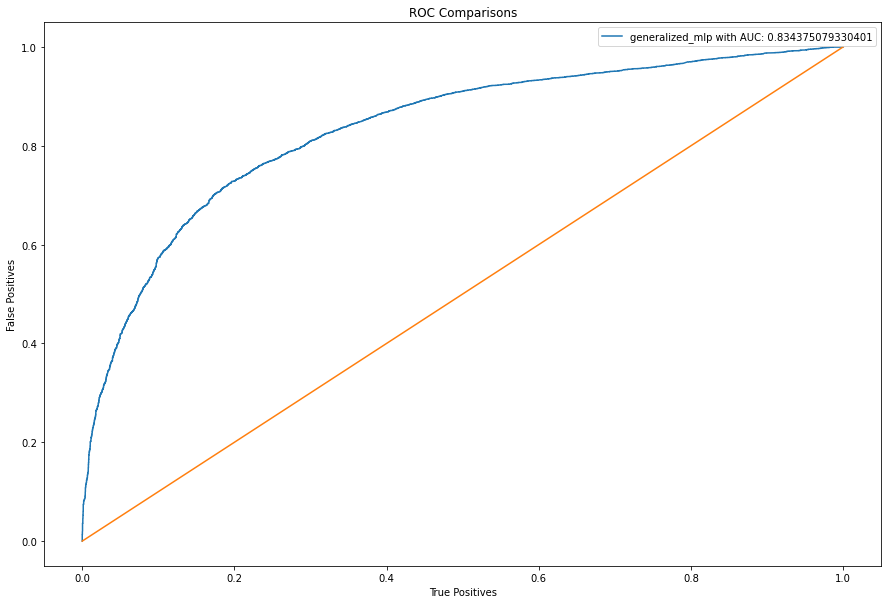

In [50]:
# plot out all model AUC
plt.figure(figsize=(15,10))
plt.title('ROC Comparisons')
plt.plot(model_fp, model_tp)
plt.plot([0, 1])
plt.ylabel('False Positives')
plt.xlabel('True Positives')
plt.legend([f"generalized_mlp with AUC: {model_roc}"])

In [51]:
# this is taken from lecture and repurposed for this exercise
import seaborn as sns
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = net.predict(X_test)
    yhat[yhat<0.5] = 0 
    yhat[yhat>=0.5] = 1
    print(yhat[yhat<=0.5])
    f1 = mt.f1_score(y_test.flatten(),yhat.flatten())
    # acc = mt.accuracy_score(y_test.flatten(),yhat.flatten())
    cm = mt.confusion_matrix(y_test,yhat)
    
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=np.unique(df["standard_value_bin"]),yticklabels=np.unique(df["standard_value_bin"]))
    plt.title(title_text+'{:.4f}'.format(f1))
    

[0. 0. 0. ... 0. 0. 0.]


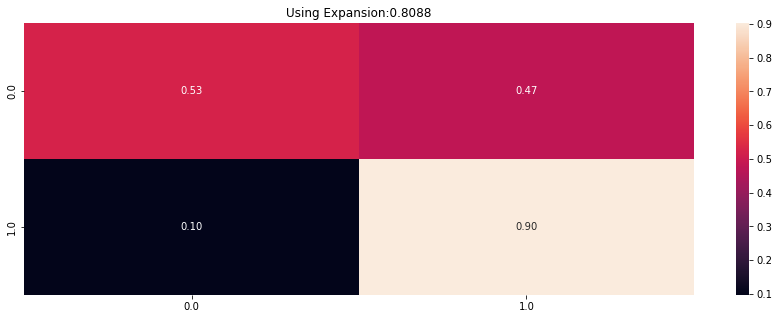

In [52]:
# summarize the last model to run
y_test_all.shape

summarize_net(model, X_test_all, y_test_all, title_text='Using Expansion:')

In [53]:
def plot_cf_matrix(model, X_test, y_test):
    # predict y using the test dataset
    yhat_proba = model.predict(X_test)
    yhat = np.round(yhat_proba)

    # assess the precision and f1_scores
    print(mt.confusion_matrix(y_test,yhat))
    print(mt.classification_report(y_test,yhat))

In [54]:
# plot the confusion matrix of the last model to run
plot_cf_matrix(model, X_test_all, y_test_all)

[[2792 2526]
 [ 748 6926]]
              precision    recall  f1-score   support

         0.0       0.79      0.53      0.63      5318
         1.0       0.73      0.90      0.81      7674

    accuracy                           0.75     12992
   macro avg       0.76      0.71      0.72     12992
weighted avg       0.76      0.75      0.74     12992



In [65]:
def plot_metrics(scores):
    # plot out loss plus metrics
    plt.figure(figsize=(15,15))
    
    plt.subplot(5,2,1)
    plt.title('Training')
    for score in scores:
        plt.plot(score["binary_crossentropy"])
    plt.ylabel('Binary Cross Entropy Loss')
    plt.legend([1,2,3,4,5])
    
    plt.subplot(5,2,3)
    for score in scores:
        plt.plot(score["recall"])
    plt.ylabel('Recall')
    
    plt.subplot(5,2,5)
    for score in scores:
        plt.plot(score["precision"])
    plt.ylabel('Precision')
    
    plt.subplot(5,2,7)
    for score in scores:
        plt.plot(score["auc"])
    plt.ylabel('AUC')
    
    plt.subplot(5,2,9)
    for score in scores:
        plt.plot(score["Accuracy"])
    plt.ylabel('Accuracy')
    
    plt.subplot(5,2,2)
    plt.title('Validation')
    for score in scores:
        plt.plot(score["val_binary_crossentropy"])
        
    plt.subplot(5,2,4)
    for score in scores:
        plt.plot(score["val_recall"])

    plt.subplot(5,2,6)
    for score in scores:
        plt.plot(score["val_precision"])

    plt.subplot(5,2,8)
    for score in scores:
        plt.plot(score["val_auc"])
        
    plt.subplot(5,2,10)
    for score in scores:
        plt.plot(score["val_Accuracy"])
        
    model_ = 1
    avg_val_f1 = []
    for score in scores:
        model_precision = sum(score["val_precision"])/len(score["val_precision"])
        model_recall = sum(score["val_recall"])/len(score["val_recall"])
        model_f1 = 2*model_precision*model_recall/(model_precision + model_recall)
        print(f"Model {model_} Validation F1:", model_f1)
        avg_val_f1.append(model_f1)
        model_ += 1
        
    print(f"Average Model Validation F1 Score:", sum(avg_val_f1)/len(avg_val_f1))

Model 1 Validation F1: 0.747909540600444
Model 2 Validation F1: 0.7480851777640941
Model 3 Validation F1: 0.748130296938596
Model 4 Validation F1: 0.748673783367724
Model 5 Validation F1: 0.7889419048040404
Average Model Validation F1 Score: 0.7563481406949798


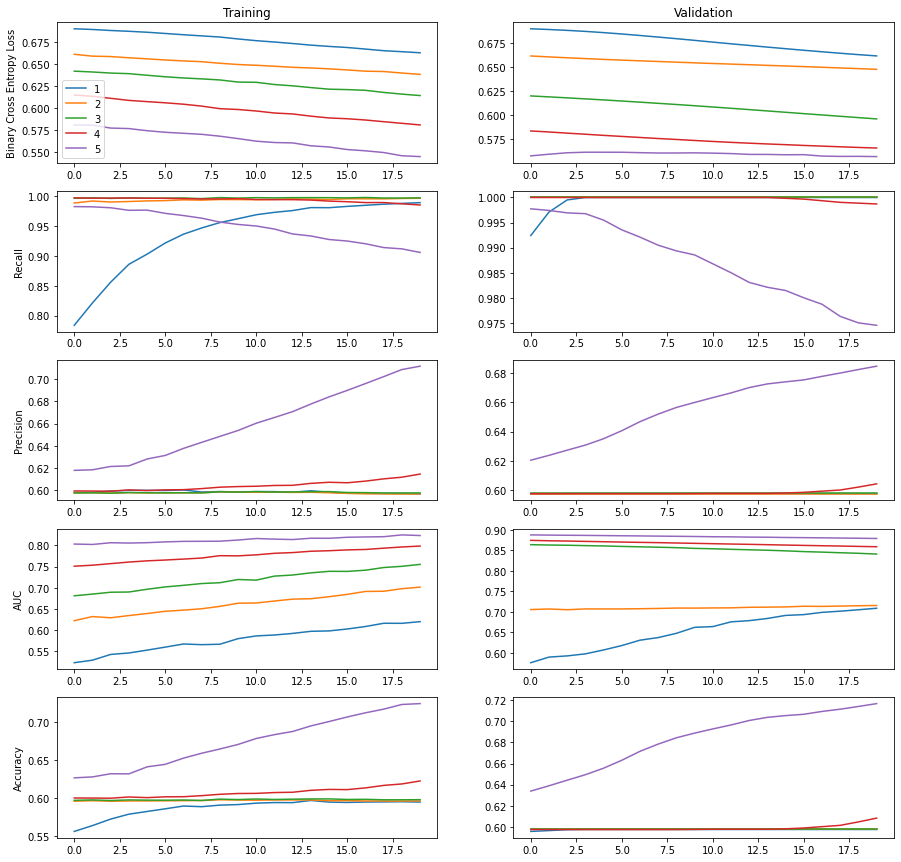

In [67]:
plot_metrics(model_scores)

In [73]:
model_avg_val_precision = avg_metric(scores=model_scores, metric="val_precision")
model_avg_val_recall = avg_metric(scores=model_scores, metric="val_recall")
model_f1 = f1_score_calc(precision=model_avg_val_precision, recall=model_avg_val_recall)

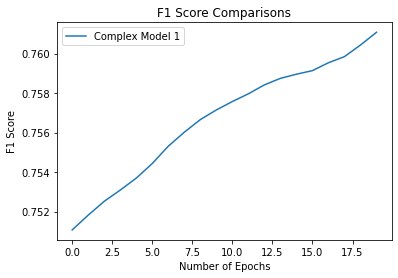

In [74]:
# plot out all model F1 scores
plt.title('F1 Score Comparisons')
plt.plot(model_f1)
plt.ylabel('F1 Score')
plt.xlabel('Number of Epochs')
plt.legend(["Complex Model 1", "Transfer Model"])

>[3.0 points] Train a multi-task model (and/or) multi-modal model. You may use any method of multi-task or multi-modal training that you like.  For multi-task models, some fine tuning of the model should be attempted. For multi-modal models, some investigation of "where to merge" the modalities should be attempted. Be sure to look at the class demonstration example for code and hints. Feel free to use this code as a starting template.

For our multi-task model, we begin by extracting the weights from our generalized model.  Because these weights are pre-trained, we set these weights to non-trainable.  Next, we assign each of these weights to their respective layers in the new shared MLP model.  To keep things consistent, we design the same model structure with the same number of neurons per layer, the same number of layers, and the same activations per layer.  Finally, we construct our model while ensuring that no layers are trainable other than the final layer.

### TODO: Maybe add dropout

In [75]:
#get weights of generalized model
w1 = model.get_layer('input_dense512').get_weights()
w2 = model.get_layer('mid_dense256').get_weights()
w3 = model.get_layer('mid_dense2_216').get_weights()
w4 = model.get_layer('mid_dense128').get_weights()
w5 = model.get_layer('mid_dense64').get_weights()
w6 = model.get_layer('mid_dense32').get_weights()
w7 = model.get_layer('mid_dense16').get_weights()
w_output = model.get_layer('output_layer').get_weights()

# set these weights
inputs = Input(shape=(X_train_all.shape[1],))
shared_input = Dense(512, activation='relu', name = 'shared_input', trainable=False)(inputs)
shared_mlp_1 = Dense(256, activation='relu', name = 'shared_middle1', trainable=False)(shared_input)
shared_mlp_2 = Dense(256, activation='relu', name = 'shared_middle2', trainable=False)(shared_mlp_1)
shared_mlp_3 = Dense(128, activation='relu', name = 'shared_middle3', trainable=False)(shared_mlp_2)
shared_mlp_4 = Dense(64, activation='relu', name = 'shared_middle4', trainable=False)(shared_mlp_3)
shared_mlp_5 = Dense(32, activation='relu', name = 'shared_middle5', trainable=False)(shared_mlp_4)
shared_mlp_6 = Dense(16, activation='relu', name = 'shared_middle6', trainable=False)(shared_mlp_5)

# make a dictionary of models for each task
models_mtl = dict()

for x in task_X_list:
    # use same architecture as the general model, but 
    #. repeat the output layer for each school  
    output_layer = Dense(1, activation='sigmoid')(shared_mlp_6)
    model_task = Model(inputs=inputs, outputs=output_layer)

    models_mtl[x[0]] = model_task
    
    shared1 = models_mtl[x[0]].get_layer('shared_input')
    shared2 = models_mtl[x[0]].get_layer('shared_middle1')
    shared3 = models_mtl[x[0]].get_layer('shared_middle2')
    shared4 = models_mtl[x[0]].get_layer('shared_middle3')
    shared5 = models_mtl[x[0]].get_layer('shared_middle4')
    shared6 = models_mtl[x[0]].get_layer('shared_middle5')
    shared7 = models_mtl[x[0]].get_layer('shared_middle6')
    personal = models_mtl[x[0]].layers[-1]
    
    # set to be the weights from the general model, as starting point
    shared1.set_weights(w1) 
    shared2.set_weights(w2)
    shared3.set_weights(w3)
    shared4.set_weights(w4)
    shared5.set_weights(w5)
    shared6.set_weights(w6)
    shared7.set_weights(w7)
    personal.set_weights(w_output)
    shared1.trainable = False
    shared2.trainable = False
    shared3.trainable = False
    shared4.trainable = False
    shared5.trainable = False
    shared6.trainable = False
    shared7.trainable = False
    personal.trainable = True

In [79]:
X_train

{'Acetylcholinesterase': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'Vascular endothelial growth factor receptor 2': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]]),
 'Epidermal growth factor receptor erbB1': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'Dihydrofolate reductase': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.,

In [ ]:
print(len(X_train))

In [99]:
# CLASSROOM CODE
def step(key_order, opt, X_train, y_train, models_mtl):
    # accumulate all the operations for the dataset
    preds = {} 
    loss = {}  
    tapes = {} 
    
    for x in key_order:
        with tf.GradientTape() as tape:
            print(x[0])
            tapes[x[0]] = tape
            # make a prediction and calculate loss for each task
            print(models_mtl[x[0]])
            preds[x[0]] = models_mtl[x[0]](X_train[x[0]])
            print(models_mtl[x[0]])
            print(X_train[x[0]])
            loss[x[0]] = mean_squared_error(y_train[x[0]], preds[x[0]])
            
    # now batch update all the models with the gradients
    for x in key_order:
        grads = tapes[x[0]].gradient(loss[x[0]], models_mtl[x[0]].trainable_variables)
        opt[x[0]].apply_gradients(zip(grads, models_mtl[x[0]].trainable_variables))

In [95]:
len(X_train["Epidermal growth factor receptor erbB1"])

2309

In [96]:
len(y_train["Epidermal growth factor receptor erbB1"])

2309

In [94]:
task_X_list[2][0]

'Epidermal growth factor receptor erbB1'

In [100]:
%%time
EPOCHS = 8
from random import shuffle

opt = {} # need separate optimizers for each output task
for x in task_X_list:
    
    opt[x[0]] = Adam() # track 

for i in range(EPOCHS):
    print('Epoch',i,end=', ')
   # shuffle(all_keys) # shuffle in place operation, maybe not needed
    
    step(task_X_list, opt, X_train, y_train, models_mtl) # batched gradient updates
    
    y_mtl=[]
    yhat_mtl=[]
    for x in task_X_list:
        # test on data, for tracking
        yhat_mlp = models_mtl[x[0]].predict(X_test,verbose=0)
        y_mtl.append(y_test.ravel())
        yhat_mtl.append(yhat_mlp.ravel())
    
    mse = mean_squared_error(np.concatenate(y_mtl), np.concatenate(yhat_mtl)) #this should probably be bce or f1, not mse, just using for now
    print('...MSE Validation:',mse.numpy())

Epoch 0, Acetylcholinesterase
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Vascular endothelial growth factor receptor 2
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
Epidermal growth factor receptor erbB1
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Dihydrofolate reductase
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Matrix metalloproteinase-2
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Protein-tyrosine phosphatase 1B
[[0. 0. 0. ... 0. 0. 0

ValueError: Data cardinality is ambiguous:
  x sizes: 276, 935, 216, 538, 253, 274, 291, 357, 374, 441, 263, 211, 578, 612, 231, 320, 233, 485, 452, 259, 279, 202, 324, 382, 272, 220, 252, 257, 204, 311, 234, 198, 320, 217, 229, 236, 287, 244, 210, 515
Make sure all arrays contain the same number of samples.